In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import dice_ml
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
from lib import *
from optimizer import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from IPython.display import display
import os
import joblib 
import mercury as mr
from matplotlib.patches import FancyArrowPatch
from sklearn.linear_model import LogisticRegression
import pylab as pl
from IPython.display import display, Markdown
import seaborn as sns
from IPython.utils import io

In [2]:
#Defining a function to create a pipeline
def create_pipeline(numeric_cols, cat_cols, X_train, y_train, X_test, y_test):
    #Global variables
    global best_params, accuracy1, y_pred, opt, best_model, dataset_name, optimization_alg, param_grid
    
    #Try to open the file with the following name. If its not found, create a new one with the according name 
    dt_name = dataset_name.split('.')[0]
    OPTIMIZERS_DICT_PATH = 'data/optimizers/' + dt_name + '_' + optimization_alg + '.pkl'
    try:
        with open(OPTIMIZERS_DICT_PATH, 'rb') as f:
            opt = joblib.load(f)
    except FileNotFoundError:
        opt = None

    if opt is None:
        #Defining the parameter grid for grid search
        numeric_transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", None)
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ("num_transform", numeric_transformer, numeric_cols),
                ("cat_transform", OneHotEncoder(handle_unknown="ignore"), cat_cols)
            ])


        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ('classifier', RandomForestClassifier(random_state=42))
        ])

        #Performing grid search with cross-validation
        optimizer = ModelOptimizer(pipeline,param_grid=param_grid,optimization_algorithm=optimization_alg)
        opt = optimizer.optimize(X_train,y_train)

    #Save the optimizers
    if not os.path.isfile(OPTIMIZERS_DICT_PATH):
        with open(OPTIMIZERS_DICT_PATH, 'wb') as f:
            joblib.dump(opt, f)

    #Getting the best hyperparameters and the corresponding model
    best_params = opt.best_params_
    best_model = opt.best_estimator_

    #Evaluating the best model on the testing set
    y_pred = best_model.predict(X_test)
    accuracy1 = accuracy_score(y_test, y_pred)

In [3]:
#Defining a function to initialize the counterfactual generation
def cf_initialization(dataframe, continuous_features, outcome_name, model, method):
    #Global variables
    global exp, d, m

    #Fitting the model on training data
    d = dice_ml.Data(dataframe=dataframe, continuous_features=continuous_features, outcome_name=outcome_name)
    m = dice_ml.Model(model=model, backend="sklearn")

    #Initializing DiCE object
    exp = dice_ml.Dice(d, m, method=method)

In [4]:
#Defining a function to calculate the Label of each row depending on GroundTruth being different or the same as y_pred
def calculate_label(X_test, y_test, y_pred):
    #Creating the test Dataframe containing the actual Y and the predicted value of Y as well as a Label column(0 if the previous ones are the same and 1 if they are different)
    dataframe = pd.concat([X_test, y_test.rename('GroundTruth')], axis=1).reset_index(drop=True)
    dataframe['Predicted'] = y_pred
    dataframe['Label'] = (dataframe['GroundTruth'] != dataframe['Predicted']).astype(int)
    return dataframe

In [5]:
#Defining a function to create a proxy
def instance_proxy(X_train, y_train, optimizer, misclassified_instance):
    #Global variables
    global numeric_cols, cat_cols, dataset_name, optimization_alg
    
    #Try to open the file with the following name. If its not found, create a new one with the according name 
    dataset_name = dataset_name.split('.')[0]
    MODELS_DICT_PATH = 'data/proxy_data_models/' + dataset_name + '_' + optimization_alg + '.pkl'
    try:
        with open(MODELS_DICT_PATH, 'rb') as f:
            trained_models = joblib.load(f)
    except FileNotFoundError:
        trained_models = {}

    #Creating proxy dataset for each hyperparameter configuration - prediction of test instance
    proxy = pd.DataFrame(columns=['Hyperparameters', 'BinaryLabel'])

    #Iterating through each hyperparameter combination
    for i, params_dict in enumerate(optimizer.cv_results_['params']):
        
        params = {key.rsplit('__', 1)[-1]: value for key, value in params_dict.items()}
        
        if i not in trained_models.keys():
            #Retraining the model with the current hyperparameters
            numeric_transformer = Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="mean")),
                ("scaler", params['scaler'])
            ])

            preprocessor = ColumnTransformer(
                transformers=[
                    ("num_transform", numeric_transformer, numeric_cols),
                    ("cat_transform", OneHotEncoder(handle_unknown="ignore"), cat_cols)
                ])

            model_name = RandomForestClassifier(
                n_estimators=params['n_estimators'],
                min_samples_split=params['min_samples_split'],
                min_samples_leaf=params['min_samples_leaf'],
                criterion=params['criterion'],
                random_state=65
            )

            mdl = make_pipeline(preprocessor, model_name)
            mdl.fit(X_train, y_train)
            trained_models[i] = mdl

        #Making prediction for the misclassified instance
        predicted_label = trained_models[i].predict(misclassified_instance.to_frame().T)
        proxy = proxy.append({'Hyperparameters': params, 'BinaryLabel': predicted_label[0]}, ignore_index=True)

    #Writing the trained models dictionary to the file
    if not os.path.isfile(MODELS_DICT_PATH):
        with open(MODELS_DICT_PATH, 'wb') as f:
            joblib.dump(trained_models, f)

    #Making sure BinaryLabel is int64
    proxy['BinaryLabel'] =proxy['BinaryLabel'].astype(np.int64)
    return proxy

In [6]:
def normalize(value, column):
    min_value = 0
    max_value = 0
    if column == 'classifier__n_estimators':
        min_value = 2
        max_value = 400
    elif column == 'classifier__min_samples_split':
        min_value = 2
        max_value = 50
    elif column == 'classifier__min_samples_leaf':
        min_value = 1
        max_value = 50
    else:
        return 0
    
    return (value - min_value) / (max_value - min_value)

In [7]:
#Defining a function to calculate the difference between the base model and each generated counterfactual
def cf_difference(base_model, cf_df):
    differences = []
    
    #Ensuring the base_model DataFrame has only one row
    if len(base_model) != 1:
        raise ValueError("Base model DataFrame must have exactly one row.")

    base_row = base_model.iloc[0]
    
    #Iterating over each row in the counterfactual DataFrame
    for index, row in cf_df.iterrows():
        difference = 0
        
        #Iterating over each column in the counterfactual DataFrame
        for column, value in row.iteritems():
            #Excluding 'BinaryLabel' column
            if column == 'BinaryLabel':
                continue
            
            #Checking if the column is numerical
            try:
                #Computing the absolute difference for numerical columns
                difference += abs(normalize(int(value), column) - normalize(int(base_row[column]), column))
            except:
                #For categorical values, difference is 1 if they are different
                if str(value) != str(base_row[column]):
                    difference += 1
                    
        #Append the difference for the current row
        differences.append(difference)
    
    #Adding the differences as a new column in the counterfactual DataFrame
    cf_df['Difference'] = differences
    
    return cf_df

In [8]:
#Defining a function for generating counterfactuals
def generate_cf(query, columns, selected_features):
    global e1, number_of_cfs, mis_id, misclassified
    
    #Generating counterfactuals using selected features
    e1 = exp.generate_counterfactuals(query, total_CFs= 100, desired_class="opposite", features_to_vary=selected_features, random_seed =123, sample_size = 5000)
    
    #Retrieving counterfactuals
    output_df = e1.cf_examples_list[0].final_cfs_df
    
    output_df = output_df[output_df['BinaryLabel'] == misclassified.loc[mis_id]['GroundTruth']]

    #Calculating differences and adding them as a new column
    output_df_with_diff = cf_difference(query[columns], output_df)
    
    #Sorting counterfactuals by the "Difference" column in ascending order
    sorted_df = output_df_with_diff.sort_values(by='Difference')
    
    #Displaying the first 10 counterfactuals with the smallest difference
    return sorted_df.head(number_of_cfs)

In [9]:
#Defining Radar class
class Radar(object):

    def __init__(self, fig, titles, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.95, 0.95]

        self.n = len(titles)
        self.angles = [a if a <=360. else a - 360. for a in np.arange(90, 90+360, 360.0/self.n)]
        self.axes = [fig.add_axes(rect, projection="polar", label="axes%d" % i) 
                        for i in range(self.n)]

        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=titles, 
                            fontsize=13, weight="normal", color="black")

        for ax in self.axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
            self.ax.yaxis.grid(False)

        #Configuring each axis with radial grids and labels
        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.set_rgrids(range(1, 6), labels=label, angle=angle, fontsize=12)
            ax.spines["polar"].set_visible(False)
            ax.set_ylim(0, 6)  
            ax.xaxis.grid(True,color='black',linestyle='-')
            pos=ax.get_rlabel_position()
            ax.set_rlabel_position(pos+3)

    #Plotting values on the chart
    def plot(self, values, *args, fill_shape=True, **kw):
        #Converting angles to radians
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        #Filling or plotting the shape based on fill_shape
        if fill_shape:
            self.ax.fill(angle, values, *args, **kw)
        else:
            self.ax.plot(angle, values, *args, **kw)

In [10]:
#Defining a function to transform parameters intointeger or string accordingly
def transform_params(mapper):
    mapper['classifier__n_estimators']['after'] = int(mapper['classifier__n_estimators']['after'])
    mapper['classifier__min_samples_split']['after'] = int(mapper['classifier__min_samples_split']['after'])
    mapper['classifier__min_samples_leaf']['after'] = int(mapper['classifier__min_samples_leaf']['after'])
    mapper['preprocessor__num_transform__scaler']['before'] = str(mapper['preprocessor__num_transform__scaler']['before'])
    return mapper

In [11]:
#Defining a function to draw the change between numerical parameters
def num_change(initial_num, final_num, last_x, variable_name):
    #Setting up the plot
    plt.figure(figsize=(8, 2))

    #Adding arrow to indicate the direction of change
    arrow = FancyArrowPatch((initial_num, 0), (final_num, 0), arrowstyle='->', mutation_scale=20, color='black', lw=2)
    plt.gca().add_patch(arrow)

    #Adding lines from axis to initial and final values
    if initial_num != final_num:
        plt.plot([initial_num, initial_num], [0, 0.05], color='red', linestyle='--') 
        plt.plot([final_num, final_num], [0, 0.05], color='green', linestyle='--')
    #If starting and final numbers are the same print the following
    elif initial_num == final_num:
        markdown_text = '<span style="font-family: Consolas, monospace; font-size: 9pt;">The starting and final numbers in the parameter below are the same!</span>'

        display(Markdown(markdown_text))

    #Adding vertical lines at initial_num and final_num with different colors
    plt.axvline(x=initial_num, color='red', linestyle='--')
    plt.axvline(x=final_num, color='green', linestyle='--')

    #title and labels
    plt.title(f'Change in {variable_name} parameter:')

    #Setting x-axis limits and ticks
    plt.xlim = (0, last_x)
    ticks = range(0, last_x + 1, int(last_x/5))
    ticks = list(ticks) + [initial_num, final_num]
    plt.xticks(ticks, ticks)

    #Removing y-axis ticks and labels
    plt.ylim(-0.5, 0.5)
    plt.yticks([])

    #Showing the plot
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()    
    plt.show()

In [12]:
#Defining a function to draw the change between criterion parameters
def criterion_change(initial_criterion, final_criterion):
    #Setting up the plot
    plt.figure(figsize=(8, 2))

    #Plotting the box with a line in the middle
    plt.plot([0.2, 0.8], [0, 0], color='white', alpha=0) 

    #Plotting a line to separate the box in two
    plt.plot([0.5, 0.5], [-0.05, 0.05], color='black')  

    #title and labels
    plt.title('Change in the Criterion parameter:')

    #Hiding the y-axis
    plt.gca().axes.get_yaxis().set_visible(False)

    #Hiding the x-axis ticks and labels
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    #Adding labels for 'Entropy' and 'Gini' inside the box
    if initial_criterion.lower() == "entropy":
        plt.text(0.33, 0, 'Entropy', fontsize=12, color='red', horizontalalignment='center', verticalalignment='center')
    else:
        plt.text(0.33, 0, 'Entropy', fontsize=12, color='black', horizontalalignment='center', verticalalignment='center')

    if initial_criterion.lower() == "gini":
        plt.text(0.66, 0, 'Gini', fontsize=12, color='red', horizontalalignment='center', verticalalignment='center')
    else:
        plt.text(0.66, 0, 'Gini', fontsize=12, color='black', horizontalalignment='center', verticalalignment='center')

    #Adding background color based on counterfactual
    if final_criterion.lower() == "gini":
        plt.axvspan(0.5, 0.8, color='lightgreen', alpha=0.5)
    elif final_criterion.lower() == "entropy":
        plt.axvspan(0.2, 0.5, color='lightgreen', alpha=0.5)

    #Showing the plot
    plt.tight_layout()
    plt.show()

In [13]:
#Defining a function to draw the change between scaler parameters
def scaler_change(initial_scaler, final_scaler):
    #Setting up the plot
    plt.figure(figsize=(8, 2))

    #Plotting the box with a line in the middle
    plt.plot([0.2, 0.8], [0, 0], color='blue', alpha=0)

    #Plotting two line to separate the box in three
    plt.plot([0.38, 0.38], [-0.05, 0.05], color='black')
    plt.plot([0.62, 0.62], [-0.05, 0.05], color='black')

    #title and labels
    plt.title('Change in the Scaler parameter:')

    #Hiding the y-axis
    plt.gca().axes.get_yaxis().set_visible(False)

    #Hiding the x-axis ticks and labels
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    #Adding labels for 'StandardScaler', 'RobustScaler', and 'MinMaxScaler' inside the boxes
    if initial_scaler == "StandardScaler()":
        plt.text(0.28, 0, 'StandardScaler', fontsize=12, color='red', horizontalalignment='center', verticalalignment='center')
    else:
        plt.text(0.28, 0, 'StandardScaler', fontsize=12, color='black', horizontalalignment='center', verticalalignment='center')

    if initial_scaler == "RobustScaler()":
        plt.text(0.50, 0, 'RobustScaler', fontsize=12, color='red', horizontalalignment='center', verticalalignment='center')
    else:
        plt.text(0.50, 0, 'RobustScaler', fontsize=12, color='black', horizontalalignment='center', verticalalignment='center')

    if initial_scaler == "MinMaxScaler()":
        plt.text(0.72, 0, 'MinMaxScaler', fontsize=12, color='red', horizontalalignment='center', verticalalignment='center')
    else:
        plt.text(0.72, 0, 'MinMaxScaler', fontsize=12, color='black', horizontalalignment='center', verticalalignment='center')

    #Adding background color based on counterfactual
    if final_scaler == "StandardScaler()":
        plt.axvspan(0.2, 0.38, color='lightgreen', alpha=0.5)
    elif final_scaler == "RobustScaler()":
        plt.axvspan(0.38, 0.62, color='lightgreen', alpha=0.5)
    elif final_scaler == "MinMaxScaler()":
        plt.axvspan(0.62, 0.8, color='lightgreen', alpha=0.5)

    #Showing the plot
    plt.tight_layout()
    plt.show()

In [14]:
#Defining a function to plot a heatmap-like object for the frequency of numerical values
def plot_frequency_heatmap(df, column):
    #Counting the frequency of each unique value in the column
    value_counts = df[column].value_counts().sort_index()
    
    #Creating a matrix for the frequency counts
    matrix = np.array([value_counts.values])
    
    #Creating the heatmap-like plot
    plt.figure(figsize=(8, 3))
    plt.imshow(matrix, cmap='Greens', aspect='auto', vmin=0)
    plt.colorbar(label='Frequency')
    plt.xticks(range(len(value_counts)), value_counts.index)
    plt.xlabel(column)
    plt.gca().yaxis.set_visible(False)
    plt.title(f'Frequency of {column} parameter')

    for i in range(len(value_counts)):
        plt.text(i, 0, str(matrix[0, i]), ha='center', va='center', color='black')
    
    plt.show()

In [15]:
#Defining a function to plot a bars for the frequency of categorical values
def plot_frequency(df, column):
    #Creating a bar plot
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=column, palette=['lightgreen', 'green'])
    plt.title(f'Frequency of {column} parameter')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    
    #Adding counts inside each bar
    ax = plt.gca()
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 5), 
                    textcoords='offset points')

    plt.show()

In [16]:
#Constants
GRID_ALG = 'grid_search'
BAYES_ALG = 'bayesian_optimization'
CATEGORICAL = ['classifier__criterion','preprocessor__num_transform__scaler']
CONTINUOUS = ['classifier__n_estimators', 'classifier__min_samples_leaf', 'classifier__min_samples_split']

#Defining the continuous features
cont_features = ['age', 'fnlwgt', 'education-num', 'capital-gain' , 'capital-loss' , 'hours-per-week']

#Defining a dictionary and creating the query instance df
factual = {
    'age': 40,
    'workclass': 'Private',
    'fnlwgt': 8556,
    'education': 'Bachelors' ,
    'education-num': 13, 
    'marital-status': 'Never-married',
    'occupation': 'Tech-support',
    'relationship': 'Not-in-family',
    'race': 'White',
    'sex': 'Male',
    'capital-gain': 52,
    'capital-loss': 0,
    'hours-per-week': 48,
    'native-country': 'United-States'}


#Defining column names
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

#Creating the Mercury application
app = mr.App(title="Counterfactuals Visualization for Adult dataset", description="", continuous_update=True)

#Defining Mercury widget to import file
dataset_name_widget = mr.File(label="Please select the file you would like to train data from:", max_file_size="10MB")

mercury.App

mercury.File

In [17]:
#File load button
load_button = mr.Button(label="Load data")
if not load_button.clicked:
    mr.Stop()

mercury.Button

In [18]:
#Getting the value from the widget
dataset_name = dataset_name_widget.filename

#Importing our data
df_all = pd.read_csv(dataset_name, header=None, names=column_names, sep=',\s*', engine='python') # adult import


#Defining Mercury widgets for the optimization algorithm and the Target column of our data
optimization_alg_widget = mr.Select(label="The optimization algorithm and the target column will be used to train the model accordingly. \nSelect optimization algorithm:", value="blue", choices=[GRID_ALG, BAYES_ALG])
target_col_widget = mr.Select(label="Select target column:",value = df.columns[-1], choices=df.columns.tolist())

mercury.Select

mercury.Select

In [19]:
#Algorithm and target colummn button
cont_button = mr.Button(label="Continue")
if not cont_button.clicked:
    mr.Stop()

mercury.Button

In [23]:
# df.head(20)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [24]:
#nan_count = df.isna().sum()
# nan_count

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [20]:
# Check for duplicate rows
duplicate_rows = df.duplicated()

# Count the number of duplicate rows
num_duplicates = duplicate_rows.sum()
# num_duplicates

In [21]:
# Drop duplicate rows
df.drop_duplicates(inplace=True)

# Reset index after dropping duplicates
df.reset_index(drop=True, inplace=True)

In [23]:
#Initial number of rows
initial_row_count = df.shape[0]

#Replace=ing "?" with NaN
df.replace('?', pd.NA, inplace=True)

#Dropping rows with any NaN values
df.dropna(inplace=True)

#Final number of rows
final_row_count = df.shape[0]

#Number of rows deleted
deleted_rows = initial_row_count - final_row_count

#Reseting index after dropping rows
df.reset_index(drop=True, inplace=True)

# print(f'Number of rows deleted due to missing values: {deleted_rows}')

In [24]:
#Getting the value from the widgets
optimization_alg = optimization_alg_widget.value
target_col = target_col_widget.value

#converting "income" column to binary type (only for adult dataset)
income_mapping = {'<=50K': 0, '>50K': 1}
df[target_col] = df[target_col].map(income_mapping)

#Dividing in X and y (features and target)
X = df.drop([target_col], axis = 1)

#Defining numeric and categorical columns
numeric_cols=X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(include='object').columns

#Setting the outcome column as y
y = df[target_col]

#Splitting in X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25 , random_state=75, stratify=y)

train = pd.concat([X_train, y_train], axis = 1)

#Setting the parameter grid to use in pipeline but also later
param_grid = {
            'preprocessor__num_transform__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__n_estimators': [2,20,200,400],
            'classifier__min_samples_split': (2,10,20,50),
            'classifier__min_samples_leaf': [1,5,10,50]   
        }

create_pipeline(numeric_cols, cat_cols, X_train, y_train, X_test, y_test)

In [25]:
#Initializing dice
cf_initialization(train, cont_features, target_col, best_model, "genetic")

#Creating the query instance
query_instance_df = pd.DataFrame([factual], index=[0])

#Generating counterfactuals for the "opposite" class
with io.capture_output() as captured:
    dice_exp = exp.generate_counterfactuals(query_instance_df, total_CFs=4, desired_class="opposite")

#Creating hyperparameters variable
hyperparameters = opt.cv_results_['params']

#Adding the Label column to the test DataFrame
test = calculate_label(X_test, y_test, y_pred)

#Creating the misclassified dataframe for all the misclassified instances and printing the length
misclassified = test[test['Label'] == 1]
print("After training the model using your inputs, some instances were classified incorrectly. \nIn the table below we can see all the misclassified instances: \n")
display(misclassified)
markdown_text2 = '<span style="font-family: Consolas, monospace; font-size: 9pt;">The <i>Label</i> column is equal to 1 in all instances where the <i>GroundTruth</i>, given by the dataset, is different than the <i>Predicted</i>, that came from the training process.</span>'
display(Markdown(markdown_text2))


After training the model using your inputs, some instances were classified incorrectly. 
In the table below we can see all the misclassified instances: 



,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,GroundTruth,Predicted,Label
9,27,Private,169662,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,42,United-States,1,0,1
10,32,State-gov,253354,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,0,1,1
17,38,Private,31069,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,4386,0,40,United-States,1,0,1
21,57,Private,34269,HS-grad,9,Widowed,Transport-moving,Unmarried,White,Male,0,653,42,United-States,1,0,1
24,26,Private,198163,Masters,14,Married-civ-spouse,Sales,Wife,White,Female,0,0,40,United-States,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,61,Private,99784,Masters,14,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,1,0,1
674,32,Self-emp-inc,110331,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,65,United-States,1,0,1
678,37,Private,186934,11th,7,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,3103,0,44,United-States,1,0,1
681,39,Self-emp-not-inc,237532,HS-grad,9,Married-civ-spouse,Sales,Wife,Black,Female,0,0,54,Dominican-Republic,1,0,1


<span style="font-family: Consolas, monospace; font-size: 9pt;">The <i>Label</i> column is equal to 1 in all instances where the <i>GroundTruth</i>, given by the dataset, is different than the <i>Predicted</i>, that came from the training process.</span>

In [26]:
#Defining Mercury widget to choose misclassified instance
mis_str = [str(x) for x in list(misclassified.index.values)]
mis_select = mr.Select(value = mis_str[0], choices = mis_str, label = "Depending on the table printed to the right, select which misclassified instance you would like to generate counterfactuals for:")

mercury.Select

In [27]:
#Misclassified button
mis_selected_btn = mr.Button(label="Select instance")
if not mis_selected_btn.clicked:
    mr.Stop()

mercury.Button

In [28]:
#Getting the value from the widget
mis_id = int(mis_select.value)

#Defining the query
query = pd.DataFrame.from_dict(best_params,orient='index').T
query['preprocessor__num_transform__scaler'] = query['preprocessor__num_transform__scaler'].astype(str)

#Defining  columns
columns = ['classifier__n_estimators', 'classifier__min_samples_split', 'classifier__criterion',
        'classifier__min_samples_leaf', 'preprocessor__num_transform__scaler']

#Defining a mercury widget for the number of counterfactuals to generate
cf_slider = mr.Slider(value=10, min=1, max=20, label="Number of counterfactuals to generate", step=1)

#Defining a mercury widget to choose which columns to change
select_cols = mr.MultiSelect(label="Please select which hyperparameters you would like to change:", 
                          value=columns, 
                          choices=columns)

mercury.Slider

mercury.MultiSelect

In [29]:
#Getting the value from the widgets
number_of_cfs = cf_slider.value
selected_col = select_cols.value

#Initializing sorted_df so it updates each time it runs
sorted_df = pd.DataFrame()

#Creating the misclassified_instance variable, as a row from the above table, to continue the rest of the proccess
misclassified_instance = misclassified.drop(columns=['GroundTruth','Label','Predicted']).loc[mis_id]

#Creating proxy dataset
proxy_dataset = instance_proxy(X_train, y_train, opt, misclassified_instance)
keys = list(proxy_dataset['Hyperparameters'].iloc[0].keys())

#Creating new columns for each key
for key in keys:
    proxy_dataset[key] = proxy_dataset['Hyperparameters'].apply(lambda x: x.get(key, None))

#Droping the original "Hyperparameters" column
proxy_dataset = proxy_dataset.drop(columns=['Hyperparameters'])

#Fixing types and names for compatibility
proxy_dataset['scaler'] = proxy_dataset['scaler'].astype(str)
proxy_dataset.rename(columns={"n_estimators": "classifier__n_estimators", "min_samples_split":"classifier__min_samples_split",
                        "criterion":"classifier__criterion", "min_samples_leaf":"classifier__min_samples_leaf", "scaler": "preprocessor__num_transform__scaler"}, inplace=True)

#Steps for column transformation and proxy model creation
cat_transf = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(), CATEGORICAL)
], remainder="passthrough")

# proxy_model = Pipeline([
#     ("one-hot", cat_transf),
#     ("svm", SVC(kernel='linear', C=2.0 ,probability=True))
# ])
proxy_model = Pipeline([
("one-hot", cat_transf),
("logistic_regression", LogisticRegression(C=2.0))
])

#Catching the error of proxy not fitting because it only found one class
proxy_fit = len(np.unique(proxy_dataset['BinaryLabel'])) != 1
if not (proxy_fit):
    print("Proxy doesn't fit for ", mis_id)
else:
    #Fitting the proxy model
    proxy_model.fit(proxy_dataset.drop(columns='BinaryLabel'), proxy_dataset['BinaryLabel'])

    #Initializing counterfactual generation
    cf_initialization(proxy_dataset, CONTINUOUS, 'BinaryLabel', proxy_model, "random")

    #Catching the error of no counterfactuals found
    try:
        with io.capture_output() as captured:
            sorted_df = generate_cf(query, columns, selected_col);
        if sorted_df.empty:
            has_cfs = False
        else:
            has_cfs = True
    except:
        has_cfs = False

    #Checking for counterfactuals
    if not has_cfs:
        print("No counterfactuals found for ", mis_id)

In [30]:
if (proxy_fit and has_cfs):
    print("Below we can see all the counterfactuals generated for the instance number" , mis_id, ": ")
    #Printing the dataframe containing the counterfactuals and making sure numerical features are Integers
    counterfactuals_df = sorted_df.reset_index(drop = True)
    counterfactuals_df[CONTINUOUS] = counterfactuals_df[CONTINUOUS].astype(int)
    display(counterfactuals_df)

Below we can see all the counterfactuals generated for the instance number 10 : 


,classifier__criterion,classifier__min_samples_leaf,classifier__min_samples_split,classifier__n_estimators,preprocessor__num_transform__scaler,BinaryLabel,Difference
0,gini,15,20,32,MinMaxScaler(),0,0.315865
1,gini,18,20,20,MinMaxScaler(),0,0.346939
2,gini,18,19,20,MinMaxScaler(),0,0.367772
3,gini,20,21,20,MinMaxScaler(),0,0.408588
4,gini,21,22,20,MinMaxScaler(),0,0.449830
5,gini,18,14,20,MinMaxScaler(),0,0.471939
6,gini,23,23,20,MinMaxScaler(),0,0.511480
7,gini,20,20,85,MinMaxScaler(),0,0.551072
8,gini,21,20,77,MinMaxScaler(),0,0.551379
9,gini,16,8,20,MinMaxScaler(),0,0.556122


In [31]:
if (proxy_fit and has_cfs):
    #Defining Mercury widget for which cf to visualise
    vis_choices = [str(x) for x in range(1, len(counterfactuals_df)+1)]
    vis_choices.append("Aggregated")
    vis_select = mr.Select(value = vis_choices[0], choices = vis_choices, label = "Select which counterfactual you would like to visualize:")

mercury.Select

In [32]:
if (proxy_fit and has_cfs):
    #Getting the value from the widget
    is_numerical = True
    try:
        vis_id = int(vis_select.value) - 1
    except:
        is_numerical = False
        vis_id = vis_select.value

    if is_numerical:
        vis_df = counterfactuals_df.iloc[vis_id]

        #Converting dictionary to DataFrame
        factual_params = pd.DataFrame([best_params])

        #Turning counterfactual into DataFrame and transposing
        cf_params = vis_df.drop(['BinaryLabel', 'Difference'])
        cf_params = pd.DataFrame(cf_params).T

        #Printing factual and counterfactual at the same table
        f_cf = pd.concat([factual_params, cf_params], axis=0).reset_index(drop=True)
        f_cf.insert(0, 'Label', ['factual:', 'counterfactual:'])
        display(f_cf)

,Label,classifier__criterion,classifier__min_samples_leaf,classifier__min_samples_split,classifier__n_estimators,preprocessor__num_transform__scaler
0,factual:,gini,1,20,20,MinMaxScaler()
1,counterfactual:,gini,16,8,20,MinMaxScaler()


In [33]:
if (proxy_fit and has_cfs):
    if is_numerical:
        #"normalizing" values in from 0 to 5 to use later, by mappings
        norm_f_cf = f_cf
        criterion_mapping = {'gini': 1, 'entropy': 4}
        scaler_mapping = {'StandardScaler()': 1, 'MinMaxScaler()': 3, 'RobustScaler()': 5}

        for i in range(2):
            norm_f_cf['classifier__criterion'][i] = criterion_mapping[f_cf['classifier__criterion'][i]]
            norm_f_cf['classifier__min_samples_leaf'][i] = f_cf['classifier__min_samples_leaf'][i] / 50 * 5
            norm_f_cf['classifier__min_samples_split'][i] = f_cf['classifier__min_samples_split'][i] / 50 * 5
            norm_f_cf['classifier__n_estimators'][i] = f_cf['classifier__n_estimators'][i] / 400 * 5
            norm_f_cf['preprocessor__num_transform__scaler'][i] = scaler_mapping[str(f_cf['preprocessor__num_transform__scaler'][i])]

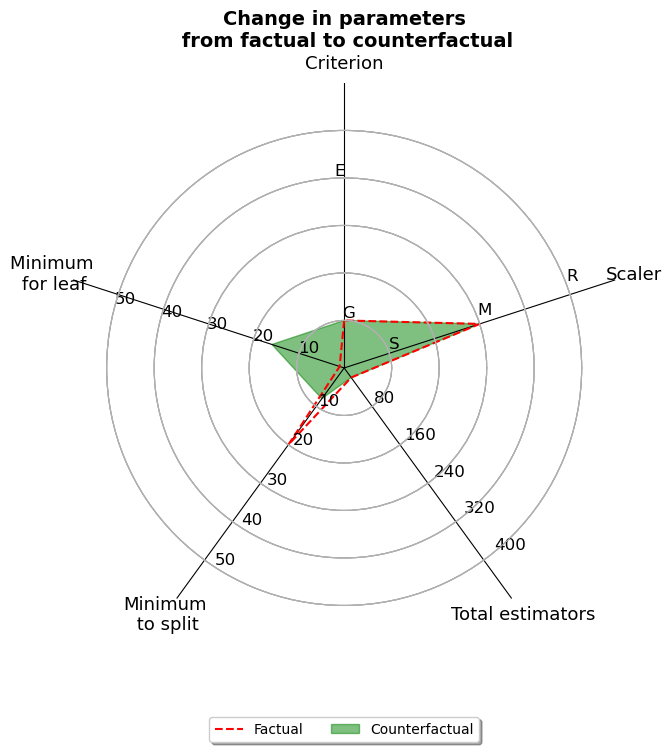

In [34]:
if (proxy_fit and has_cfs):
    if is_numerical:
        fig = pl.figure(figsize=(9, 20))

        #Adding normalized values in a list
        norm_list = norm_f_cf.drop(['Label'], axis=1).values.tolist()

        #Adding the titles and labels for each of the radii
        titles = ['Criterion', 'Minimum \nfor leaf',
            'Minimum\n to split', 'Total estimators',
            'Scaler']

        labels = [
        ["G","","","E",""],
        ["10","20","30","40","50"],
        ["10","20","30","40","50"],
        ["80", "160", "240", "320", "400"],
        ["S","", "M","", "R"]
        ]

        #Creating the plot
        radar = Radar(fig, titles, labels)

        #Plotting the shapes
        radar.plot(norm_list[0], "--", lw=1.5, color="r", alpha=1, label="Factual", fill_shape=False)
        radar.plot(norm_list[1], "", lw=1, color="g", alpha=0.5, label="Counterfactual", fill_shape=True)

        #Addig legend
        radar.ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
            fancybox=True, shadow=True, ncol=4)

        #Adding title
        radar.ax.set_title("Change in parameters\n from factual to counterfactual", weight = "bold", fontsize = 14)
        
        #Showing plot and setting size
        fig = plt.gcf()
        fig.set_size_inches(6, 10, forward=True)

In [35]:
if (proxy_fit and has_cfs):
    if is_numerical:
        #Printing explainations for the Radar chart
        print("On the Radar Chart above we can see clearly the difference between Factual and Counterfactual")
        print("On the 'Criterion' radius, G stands for gini and E for entropy.")
        print("Likewise, on the 'Scaler' radius, S stands for StandardScaler, M for MinMaxScaler and R for RobustScaler.")

On the Radar Chart above we can see clearly the difference between Factual and Counterfactual
On the 'Criterion' radius, G stands for gini and E for entropy.
Likewise, on the 'Scaler' radius, S stands for StandardScaler, M for MinMaxScaler and R for RobustScaler.


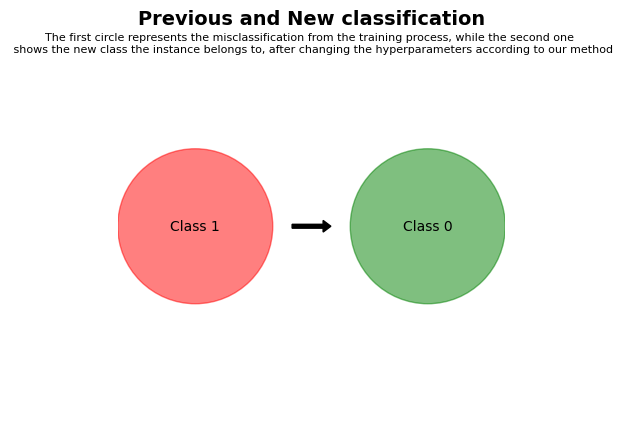

In [36]:
if (proxy_fit and has_cfs):
    if is_numerical:
        new_class = counterfactuals_df.iloc[vis_id][-2].astype(int)
        old_class = misclassified.loc[mis_id][-2].astype(int)

        #Creating figure and axis
        fig, ax = plt.subplots(figsize=(5, 9))

        #Drawing the circles
        circle1 = plt.Circle((0.2, 0.5), 0.2, color='red', alpha=0.5)
        ax.add_artist(circle1)
        circle2 = plt.Circle((0.8, 0.5), 0.2, color='green', alpha=0.5)
        ax.add_artist(circle2)

        #Drawing the arrow
        arrow = plt.Arrow(0.45, 0.5, 0.1, 0, width=0.05, color='black')
        ax.add_patch(arrow)

        #Adding text inside the circles
        ax.text(0.2, 0.5, 'Class {}'.format(old_class), color='black', va='center', ha='center')
        ax.text(0.8, 0.5, 'Class {}'.format(new_class), color='black', va='center', ha='center')

        #Setting aspect of the plot to be equal
        ax.set_aspect('equal')

        #Setting axis limits
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        #Removing axes
        ax.axis('off')

        #Adding title and subtitle 
        ax.set_title('Previous and New classification', weight = "bold", fontsize = 14)
        plt.text(0.5, 0.95, 'The first circle represents the misclassification from the training process, while the second one \n shows the new class the instance belongs to, after changing the hyperparameters according to our method', horizontalalignment='center', fontsize=8, transform=ax.transAxes)

        #Showing the plot
        plt.show()


Below we can see he changes in each of the columns. The red color indicates the starting point, the value 
of the 'factual' while the green color indicates the value provided by the counterfactual chosen to be visualized.


<span style="font-family: Consolas, monospace; font-size: 9pt;">The starting and final numbers in the parameter below are the same!</span>

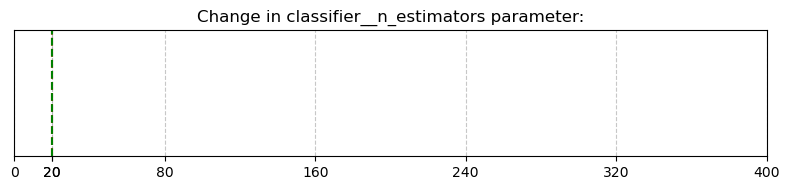

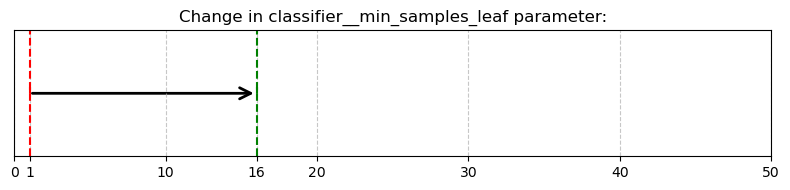

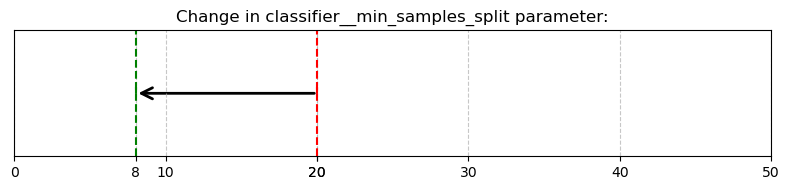

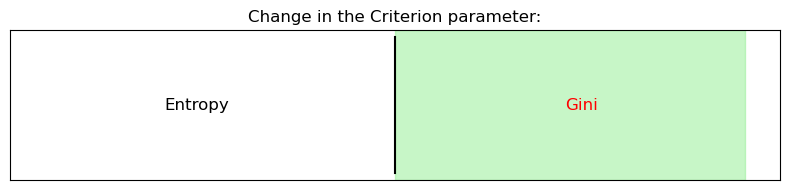

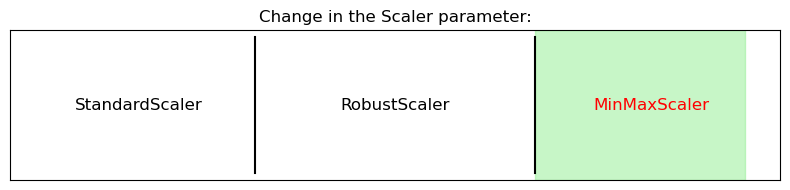

In [37]:
if (proxy_fit and has_cfs):
    if is_numerical:
        #Creating a mapper to store the previous and after values
        vis_mapper = {}

        for j in columns:
            vis_mapper[j] = {'before': best_params[j], 'after': vis_df[j]}
        vis_mapper = transform_params(vis_mapper)

        print("Below we can see he changes in each of the columns. The red color indicates the starting point, the value \nof the 'factual' while the green color indicates the value provided by the counterfactual chosen to be visualized.")

        #Making plots for continuous columns
        for con in CONTINUOUS:
            num_change(vis_mapper[con]['before'], vis_mapper[con]['after'], param_grid[con][-1], con)

        #Making plots for categorical columns
        criterion_change(vis_mapper['classifier__criterion']['before'], vis_mapper['classifier__criterion']['after'])
        scaler_change(vis_mapper['preprocessor__num_transform__scaler']['before'], vis_mapper['preprocessor__num_transform__scaler']['after'])

In the plots below we can see the freqency of each parameter value from the generated counterfactuals


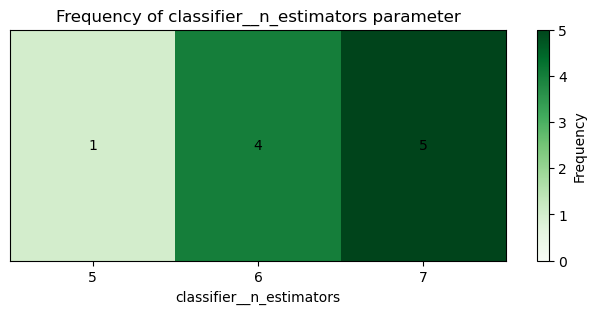

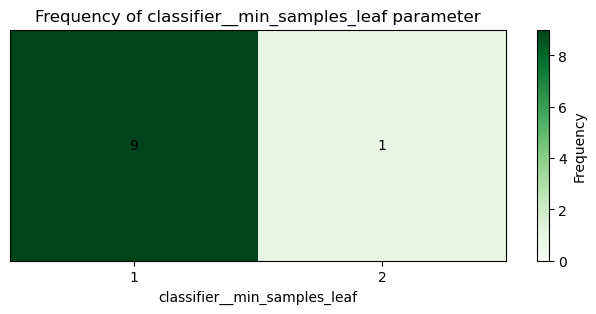

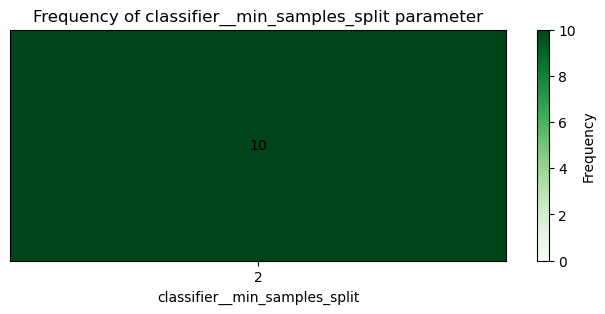

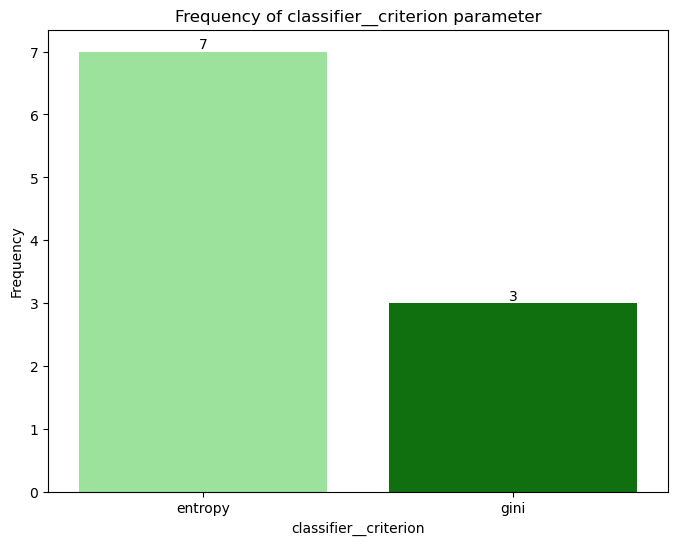

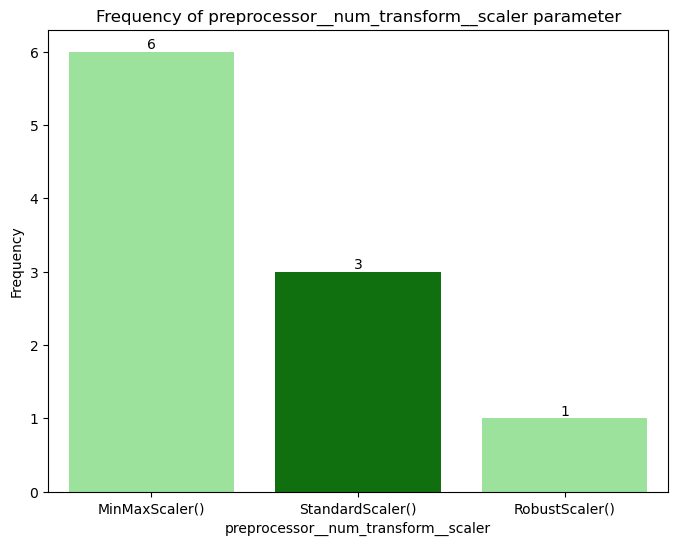

In [36]:
if (proxy_fit and has_cfs):
    if not is_numerical:
        print("In the plots below we can see the freqency of each parameter value from the generated counterfactuals")
        plot_frequency_heatmap(counterfactuals_df,'classifier__n_estimators')
        plot_frequency_heatmap(counterfactuals_df, 'classifier__min_samples_leaf')
        plot_frequency_heatmap(counterfactuals_df, 'classifier__min_samples_split')
        plot_frequency(counterfactuals_df,'classifier__criterion')
        plot_frequency(counterfactuals_df, 'preprocessor__num_transform__scaler')
    